In [1]:
%load_ext autoreload
%autoreload 2

### Importation des bibliothèques

In [2]:
from tqdm import tqdm
from collections import Counter, defaultdict
import os
os.chdir("..")

# my modules
from Preprocessors.ReviewPreprocessor import ReviewPreprocessor
from Aspects.ExplicitAspectExtractor import ExplicitAspectExtractor
from Aspects.CoRefAspectIdentGrouping import CoRefAspectIdentGrouping

# pandas and numpy
import pandas as pd
import numpy as np

# spacy for NLP
import spacy
from spacy.matcher import Matcher
from spacy import displacy

from time import time

#ignore pandas warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plots
import matplotlib.pyplot as plt
import seaborn as sns

nlp = spacy.load("en_core_web_sm")

### Importation des données

le dataset utilisé 3000 commentaires, extraite depuis une grande dataset de 50 Million commentaires dans TripAdvisor. [lien vers le dataset](https://www.aclweb.org/anthology/2020.lrec-1.605)

les attributes de dataset créé:
- **hotel_url**: lien de l'hotel commenté;
- **author**: l'auteur de commentaire;
- **date**: date de publication de commentaire;
- **rating**: le score attribué par l'auteur à l'hotel;
- **title**: titre de commentaire;
- **review**: le text de commentaire.

In [134]:
data = pd.read_csv("data/trip_advisor_data_chunk_10000k.csv", encoding="utf-16")
data.rename(columns={"text": "review"}, inplace=True)
print(f"format de dataset: {data.shape}")
data.head(5)

format de dataset: (3000, 6)


,hotel_url,author,date,rating,title,review
0,Hotel_Review-g194775-d1121769-Reviews-Hotel_Ba...,Lagaiuzza,2016-01-01T00:00:00,5.0,"Baltic, what else?",We have spent in this hotel our summer holiday...
1,Hotel_Review-g194775-d1121769-Reviews-Hotel_Ba...,ashleyn763,2014-10-01T00:00:00,5.0,Excellent in every way!,I visited Hotel Baltic with my husband for som...
2,Hotel_Review-g194775-d1121769-Reviews-Hotel_Ba...,DavideMauro,2014-08-01T00:00:00,5.0,The house of your family's holiday,I've travelled quite a numbers of hotels but t...
3,Hotel_Review-g303503-d1735469-Reviews-Pousada_...,TwoMonkeysTravel,2017-03-01T00:00:00,5.0,Natural Luxury,"The property is surrounded by trees, which are..."
4,Hotel_Review-g303503-d1735469-Reviews-Pousada_...,analuizade,2016-09-01T00:00:00,5.0,Very cozy!,I had a very pleasant stay at this hotel! All ...


### Prétraitement de données

#### suppression des caractéristiques inutiles. (\n, \t, \r, hyperlinks, #..., @..., les emojis)

Après l'analyse des commentaires. Nous avons remarqué que le dataset contient des mots en dialecte marocain -darija-. Ainsi nous les considérons comme des mots corrects.

In [135]:
data["cleaned_review"] = data['review']
preprocessor = ReviewPreprocessor(data['cleaned_review'], spell_allowed_words= ["riad", "dar","rif"], nlp=nlp, subjectivity_threshold=0.6)
data['cleaned_review'] = preprocessor.remove_tags()
data['cleaned_review']

0       We have spent in this hotel our summer holiday...
1       I visited Hotel Baltic with my husband for som...
2       I've travelled quite a numbers of hotels but t...
3       The property is surrounded by trees, which are...
4       I had a very pleasant stay at this hotel! All ...
                              ...                        
2995    We stayed in Portland for three nights and thi...
2996    It was my third time to stay at University pla...
2997    Stayed here for 4 nights in March and I chose ...
2998    I didn't expect much from this hotel from the ...
2999    The hotel rooms were clean and comfortable. Ni...
Name: cleaned_review, Length: 3000, dtype: object

#### transformation en miniscule

In [136]:
data["cleaned_review"] = data["cleaned_review"].apply(lambda r : r.lower())

#### correction des fautes d'orthographes

Pour la correction des fautes d'orthographes, nous avons adopté la procédure suivante: premièrement, on parcourt les commentaires une par une. Ensuite on extrait les mots de commentaire traitée. On utilise la bibliothèque **pyspellchecker**, qui utilise la norme de levenshtein pour corriger les mots mal tapés.

Pour vérifier la procédure. nous modifions le commentaire d'indice 0:

**Contenu de commentaire**
'We have spent in this hotel our summer holidays both in summer 2014 and 2015- I was with my husband and my child ( 4 years old at present). I do really recommend this place- Staff si high qualified, Kind and really helpful- Animation staff get You involved, but always with discrection - Miniclub si super and activities offered are interesting and smart- Rooms clean, with AC and balcony- Restaurant offers a great selection of food - always. The beach si extremly closed to the hotel - Miniclub area offers some gazebos to have shade for kids- A lot of bicycles are available for free- I am completely satisfied of this hotel- Go in lime this!'

les modification appliqué:
- We -> Wee
- have -> haavee
- spent -> spant
- in -> ine

In [137]:
data.loc[0, "review"] = 'Wee haavee spant ine this hotel our summer holidays both in summer 2014 and 2015- I was with my husband and my child ( 4 years old at present). I do really recommend this place- Staff si high qualified, Kind and really helpful- Animation staff get You involved, but always with discrection - Miniclub si super and activities offered are interesting and smart- Rooms clean, with AC and balcony- Restaurant offers a great selection of food - always. The beach si extremly closed to the hotel - Miniclub area offers some gazebos to have shade for kids- A lot of bicycles are available for free- I am completely satisfied of this hotel- Go in lime this!'
data.loc[0, "review"]

'Wee haavee spant ine this hotel our summer holidays both in summer 2014 and 2015- I was with my husband and my child ( 4 years old at present). I do really recommend this place- Staff si high qualified, Kind and really helpful- Animation staff get You involved, but always with discrection - Miniclub si super and activities offered are interesting and smart- Rooms clean, with AC and balcony- Restaurant offers a great selection of food - always. The beach si extremly closed to the hotel - Miniclub area offers some gazebos to have shade for kids- A lot of bicycles are available for free- I am completely satisfied of this hotel- Go in lime this!'

In [138]:
data['cleaned_review'] = preprocessor.spelling_correction()
data['cleaned_review'][0]

1363it [06:06,  3.72it/s]


KeyboardInterrupt: 

les mots modifier dans le commentaires avec indice 0 sont bien corrigés, mais le mot 'si' n'est pas corrigé.

#### suppression des phrases objectives

In [ ]:
data['cleaned_review'] = preprocessor.remove_objective_sentences()
data['cleaned_review'][0]

les phrases supprimé dans le commentaire 0 :
- We have spent in this hotel our summer holidays both in summer 2014 and 2015
- Staff si high qualified, Kind and really helpful- Animation staff get You involved, but always with discrection
- The beach si extremly closed to the hotel - minicab area offers some gazebos to have shade for kids-


In [8]:
from textblob import TextBlob
TextBlob("Staff si high qualified, Kind and really helpful- Animation staff get You involved, but always with discrection").subjectivity

0.5466666666666666

In [9]:
TextBlob("Staff si high qualified, Kind and really helpful").subjectivity

0.5466666666666666

In [10]:
TextBlob("Animation staff get You involved, but always with discrection").subjectivity

0.0

In [11]:
TextBlob("I was with my husband and my child ( 4 years old at present)").subjectivity

0.1

**Remarques:**
- la deuxième phrase est supprimé à cause de son score de subjectivité inférieur au seuil 0.6
- il y a un problème dans l'étape de prétraitement. dans le cas de la phrase le symbole '-' est lié à l'adjectif helpful, car dans cette commentaire l'auteur à écrit une liste des phrases et lors de la suppression de \n, le symbole '-' sera concaténé par le mot qui le précède.

### Extraction des aspects explicites

Dans cette phase, on extrait les noms les plus fréquents comme des aspects explicites.

In [ ]:
now = time()
aspect_extractor = ExplicitAspectExtractor(data["cleaned_review"], nlp)
extracted_aspects = aspect_extractor.start(60)
print(extracted_aspects)
print(f"extracting aspects {time() - now}s")

on remarque que les aspects les plus fréquents sont:
- room
- hotel
- staff
- location
- breakfast
- time
- restaurant
- service
- stay

...

### Groupement des aspects similaires (Co-referencial aspect identification and grouping)

Après l'extraction des aspects explicites. L'objectif de cette étape est le groupements des aspects explicite qui ont un sens similaire, exemple le groupe (food, breakfast, dinner).

Pour atteindre cette objectif, nous proposons d'utiliser le modèle **Word2Vec**. ce dernier est entraîné sur les phrases des commentaires. Ensuite, pour chaque couple d'aspects explicites, on calcule la similarité entre eux à l'aide du modèle construit.

On calcule la matrice de cooccurrence entre les aspects explicites et les mots qui exprime un sentiment (des adjectifs). Cette matrice sera utilisée pour l'extraction des aspects implicites.

#### Création de la matrice de co-occurrence entre les aspects explicite et les mots de sentiments

In [ ]:
aspects_ = list(dict(extracted_aspects).keys())

In [ ]:
co_ref_aspect_ident_grouping = CoRefAspectIdentGrouping(data[["review", "cleaned_review"]], dict(extracted_aspects), nlp)
aspect_sentiment = co_ref_aspect_ident_grouping.get_co_occurrence_matrix()
aspect_sentiment

#### Groupement des aspects explicites

la procédure proposé crée des couples des aspects explicites similaire, exemple:

Ensuite, on applique un algorithme pour grouper les couples qui ont au moins un élément partagé, et d'une manière récursive.

Le résultat de groupement:

In [ ]:
co_ref_aspects = co_ref_aspect_ident_grouping.get_co_reference_aspects_groups(0.68)
co_ref_aspects

### Extraction des aspects implicites

La procédure proposée est inspirée de l'article [2]. Premièrement on identifie les phrases subjectives qui ne contiennent pas un aspect explicite, puis on extrait les adjectifs (sentiments) dans cette phrase, afin de trouver les aspects explicites qui coexistent fréquemment avec chaque adjectif.

In [ ]:
aspects = list(dict(extracted_aspects).keys())

In [ ]:
pattern = [{"POS": "ADJ"}]
matcher = Matcher(nlp.vocab)
matcher.add("SENTIMENT_WORDS", [pattern])

for id_, review in data["cleaned_review"].items():
    doc = nlp(review)
    for sentence in doc.sents:
        aspects_in_sentence = [i for i in aspects if i in sentence.text.lower()]
        if len(aspects_in_sentence) == 0:
            print(f"review id : {id_}")
            # extract ADJ
            adjs = matcher(sentence)
            for id_matcher, start, end in adjs:
                sentiment_word = sentence[start:end].text
                if sentiment_word in list(aspect_sentiment.index):
                    implicit_aspect = aspect_sentiment.loc[sentiment_word].sort_values(ascending=False).index[0]
                    print(f"sentiment word : {sentiment_word}, aspect : {implicit_aspect}")
                    print(sentence.text)
            print("=========")

In [ ]:
from Aspects.ImplicitAspectExtractor import ImplicitAspectExtractor

In [ ]:
implicit_aspect_extractor = ImplicitAspectExtractor(data["cleaned_review"], aspect_sentiment, nlp)
df_implicit_aspects = implicit_aspect_extractor.extract_implicit_aspects()
df_implicit_aspects

Après l'application de l'algorithme proposé, on remarque qu'on obtient quelque bon extraction. comme :

malheureusement, il y a des aspects implicite pas bien identifier, comme:

**Remarques:**
- la méthode proposé dans l'extraction des aspects implicite n'analyse pas le context de la phrase, c'est pour cela on obtient des aspects mal identifiée comme dans la phrase 1545, 1050, 2682
- dans la phrase 1050, on remarque un mention explicite de l'aspect 'Staff' par le mot employee, mais on identifie les aspects implicite 'hotel' et 'breakfast'.
- de même pour 2904, l'aspect explicite value et en identifier un aspect implicite 'staff'.

### Les Idées d'amélioration:

#### Prétraitement:

- le processus de correction prend  beaucoup de temps (plus de 11 minutes pour corriger 3000 commentaires). utilisation de calcul parallèle pour traiter plusieurs commentaires en même temps.
- parfois les auteurs utilise des liste dans leurs commentaires. exemple :

Avec la suppression de symbole '\n', les éléments de la liste serait concaténé, ce qui affect la division de commentaires en phrases.

#### Extraction des aspects explicites:

- utilisation de modèle **Word2Vec** Pour extraire les aspects explicites non-fréquents, en calculons la similarité entre un aspect explicite et un aspect explicite non-fréquent.

#### Co-reference aspects identification and grouping

- fixer un nombre maximum d'éléments pour les groupes d'aspects similaires.

### Idée de pour la classification des sentiments:

- Utilisation de NLP pour lier les aspects avec ses mots de sentiment dans chaque phrase. Après on utilise le corpus SentiWordNet avec des règles linguistiques pour déterminer la polarité de l'aspects discuté dans la phrase [3].
- Utilisation d' algorithmes non supervisés.

### Classification des sentiments:

##### code de la méthode

In [20]:
# Load opinion lexicon
neg_file = open("data/opinion-lexicon-English/negative_words.txt",encoding = "ISO-8859-1")
pos_file = open("data/opinion-lexicon-English/positive_words.txt",encoding = "ISO-8859-1")
neg = [line.strip() for line in neg_file.readlines()]
pos = [line.strip() for line in pos_file.readlines()]
opinion_words = neg + pos

In [21]:
def feature_sentiment(sentence):
    '''
    input: dictionary and sentence
    function: appends dictionary with new features if the feature did not exist previously,
              then updates sentiment to each of the new or existing features
    output: updated dictionary
    '''

    sent_dict = Counter()
    debug = 0
    for token in sentence:
    #    print(token.text,token.dep_, token.head, token.head.dep_)
        # check if the word is an opinion word, then assign sentiment
        if token.text in opinion_words:
            sentiment = 1 if token.text in pos else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            if (token.dep_ == "advmod"):
                continue
            elif (token.dep_ == "amod"):
                for child in token.children:
                    # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if child.dep_ == "neg":
                        sentiment *= -1
                sent_dict[token.head.lemma_.lower()] += sentiment
            # for opinion words that are adjectives, adverbs, verbs...
            else:
                for child in token.children:
                    # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if child.dep_ == "neg":
                        sentiment *= -1
                for child in token.children:
                    # if verb, check if there's a direct object
                    if (token.pos_ == "VERB") & (child.dep_ == "dobj"):
                        sent_dict[child.lemma_.lower()] += sentiment
                        # check for conjugates (a AND b), then add both to dictionary
                        subchildren = []
                        conj = 0
                        for subchild in child.children:
                            if subchild.text == "and":
                                conj=1
                            if (conj == 1) and (subchild.text != "and"):
                                subchildren.append(subchild.lemma_.lower())
                                conj = 0
                        for subchild in subchildren:
                            sent_dict[subchild] += sentiment

                # check for negation
                for child in token.head.children:
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if (child.dep_ == "neg"):
                        sentiment *= -1
                
                # check for nouns
                for child in token.head.children:
                    noun = ""
                    if (child.pos_ == "NOUN") and (child.text not in sent_dict):
                        noun = child.lemma_.lower()
                        # Check for compound nouns
                        for subchild in child.children:
                            if subchild.dep_ == "compound":
                                noun = subchild.lemma_.lower() + " " + noun
                        sent_dict[noun] += sentiment
                    debug += 1
    return sent_dict

la méthode utilisé pour la classification a été proposé dans une blog [lien de blog](https://medium.com/@pmin91/aspect-based-opinion-mining-nlp-with-python-a53eb4752800) intitulé "Aspect-Based Opinion Mining (NLP with Python)".

La méthode se base sur un lexique d'opinion proposé par Hu et Liu [lien vers le lexicon](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon), pour déterminer la polarité d'un mot. Le lexique contient 6'800  mots divisés en mots positifs et négatifs.

Cette méthode parcourt tous les tokens (mots, ponctuation, numéros, ...) dans la phrase traitée. Si le mot traité est dans le lexicon, on obtient sa polarité à partir de la liste (pos ou neg) où il appartient. Ensuite on utilise la technique [Dependency Parsing](https://realpython.com/natural-language-processing-spacy-python/#dependency-parsing-using-spacy) [(explication profond)](https://web.stanford.edu/~jurafsky/slp3/14.pdf), pour récupérer la dépendance grammaticale entre le token traité (sentiment) et les autres token dans la phrase, afin d'extraire l'aspect dont le sentiment est lié.

#### Procédure de la méthode:
- Parcourir tous les tokens dans la phrase traitée;
- Si le token est dans le corpus des mots de sentiments:
- Vérifier si le mot positif affecte un score de 1, si non affecter un score de -1.
    - Si le token s’agit d’un adverb comme ‘highly’ or ‘pretty” on l’ignore
    - Si le mot s’agit d’un adjectif on extrait le mot dont il est lié comme un aspect, également on vérifie si l'adjectif lié à une négation et a un mot d'intensité pour augmenter l’intensité de sentiment. exemple :

In [55]:
displacy.render(nlp("rooms not very clean"))

In [59]:
feature_sentiment(nlp("rooms not very clean"))

Counter({'room': -1.5})

- Si la phrase plus complexe on applique les règles suivant:
    - on parcourt enfant de token (sentiment) (lignes 24-31) pour détecter si il est lié un mot d’intention adverbes (ex: very, highly,...), on multiple le sentiment par 1.5 (lignes 27-28), on vérifie s' il est lié à un mot de négation pour inverser le sentiment.
    - Si le token traité (sentiment) s’agit d’un verb comme dans la phrase “I didn't like this hotel and its staff.”, dans ce cas l’aspect sera l’objet direct de verb (lignes  43-44), si un autre aspect discuter (avec une conjonction ‘and’ ) dans la phrase, il sera également extrait égale a celui du parent.

In [48]:
displacy.render(nlp("I didn't like this hotel and its staff."))

In [51]:
feature_sentiment(nlp("I didn't like this hotel and the staff"))

Counter({'hotel': -1, 'staff': -1})

- Si les règles précédentes n'étaient pas respectées.
    - On traite le parent de token traité (mot de sentiment), pour vérifier la négation et les mots d’intensité (lignes 57-62). Ensuite on extrait les noms liés au parent comme un aspect explicite (lignes 65-73). exemple “the staff wasn’t friendly”.

In [52]:
displacy.render(nlp("the staff wasn't friendly"))

In [54]:
feature_sentiment(nlp("the staff wasn't friendly"))

Counter({'staff': -1})

In [22]:
def extract_sentiment_aspect(review):
    sentences = nlp(review).sents
    res = []
    for sentence in sentences:
        f = feature_sentiment(sentence)
        # don't add empty objects
        if f != {}:
            res.append(f)
    return res

In [ ]:
data["aspect_sentiment"] = data["cleaned_review"].apply(lambda review: extract_sentiment_aspect(review))
data["aspect_sentiment"]

#### Affichage des commentaires avec un score inférieur ou égale à 2 avec le résultat de la classification

**Remarque:** Chaque objet Counter représente les aspects extraits avec leur polarité dans la phrase traitée.

In [50]:
for id_, items in data[data["rating"] <= 2]["aspect_sentiment"].items():
    print(f"reviews {id_} : {data.loc[id_, 'cleaned_review']} \n {items} \n ======================")

reviews 1506 : unpaved drive, badly lit. breakfast poor- tinned fruit instead of fresh. 2.5 am from city centre reached via the previously mentioned drive followed by a walk along a main road with no footpath. 
 [] 
reviews 1507 : my wife and i were booked into a superior room at this hotel for 5 nights as part of a 3 week tour of argentina. we chose this hotel based upon the reference to spectacular views and the facilities such as restaurant and swimming pool and ease of location to brioche town.. the room was clean and the view was indeed great looking out over the lake. the hotel restaurant only provided a buffet meal in the evenings and having experienced eating there at breakfast ( which was like a site canteen with closely packed tables and no table cloths) we decided not to avail ourselves of this amenity also there is no bar in which to relax after those long days of sightseeing. the access road comprises a steep dirt track which is unsuitable for walking on except in walking 

#### Limitations de la méthode

la méthode souffre de plusieurs limitations:
- Incapable de traiter les aspects implicite.

In [133]:
feature_sentiment(nlp("the hotel is walking distance (5 min) to the center of town, and near a small park."))

Counter()

- Il y a des phrase qui ne réspecte pas les régles d'extraction, par concequence aucune aspect/sentiment sera extrait, malgrai que la phrase discute un sentiment sur un aspect, ou bien il tampe dans l'extraction des aspects

    Exemples:
    - comme dans le cas de la phrase suivant 'Every time I come here, staff members welcome me warmly and they are really friendly and helpful.' il a extrait le pronom personnel **i** (la forme lemmatisé de 'me') comme un aspect positive et le nom **time** comme un aspect positive

In [96]:
feature_sentiment(nlp("Every time I come here, staff members welcome me warmly and they are really friendly and helpful."))

Counter({'i': 1.5, 'time': 2.25, 'staff member': 2.25})

In [84]:
displacy.render(nlp("Every time I come here, staff members welcome me warmly and they are really friendly and helpful."))

In [132]:
feature_sentiment(nlp("my room had no hot water and the staff was unconcerned and unhelpful."))

Counter({'water': 1})

    - les aspects dans cette phrase sont room et staff, mais la méthode a extrait water comme un aspect positif, car les règle utilisé ne sont pas respecté.
    - La méthode extrait l'aspect staff si on permute les adjectifs 'unconcerned' et 'unhelpful' car le premier n'est pas dans le lexicon utilisé.

In [117]:
displacy.render(nlp("my room had no hot water and the staff was unconcerned and unhelpful."))

In [134]:
feature_sentiment(nlp("this really is an exceptional small hotel, and i recommend it 100%."))

Counter({'hotel': 1, 'it': 1})

    - la méthode a bien extrait l'aspect hotel avec un sentiment positif, également il a extrait le pronom 'it' comme aspect positif. Dans ce cas, on doit détecter l'aspect sur lequel il réfère.

### Représentation graphique des résultats de classification

#### agrégation des résultats

In [42]:
aspects_summary_ = pd.DataFrame(columns= ["aspect", "sentiment", "score"])

In [43]:
for id_, items in tqdm(data["aspect_sentiment"].items()):
    to_append = []
    for item in items:
        for i in item:
            if i in aspects_:
                to_add = pd.Series([i, "positive" if item[i] > 0 else "negative", item[i]], index = ["aspect", "sentiment", "score"])
                aspects_summary_ = aspects_summary_.append(to_add, ignore_index=True)                

3000it [01:46, 28.17it/s]


#### Affichage des sentiments à propos des 10 premiers aspects.

In [26]:
palette = sns.color_palette("tab10")

In [44]:
groped_aspects_summary_ = aspects_summary_.groupby(["aspect", "sentiment"]).size().reset_index(name="count").sort_values("count", ascending=False)

In [45]:
plot_first_five_aspects = groped_aspects_summary_.query("aspect==['room','hotel','staff','breakfast','food','place','restaurant','time','night','day']")

<AxesSubplot:xlabel='aspect', ylabel='count'>

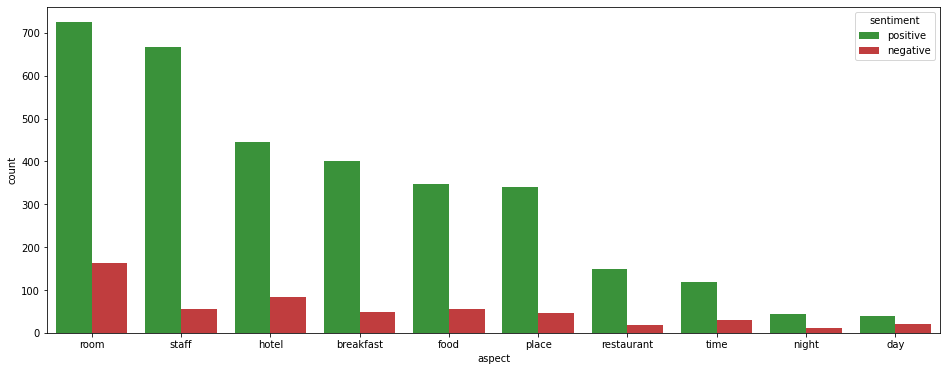

In [46]:
plt.figure(figsize=(16, 6))
sns.barplot(x = "aspect", y="count", hue="sentiment", data=plot_first_five_aspects, palette={"negative": palette[3], "positive":palette[2]})

**Remarque:**
- remarque une dominance des sentiments positive à propos des premiers 10 aspects. Les aspects plus commenté positivement sont room, staff, hotel, breakfast, et food.
- les aspects room, hotel, food sont les plus commenté négativement.
- l'aspect room est apparu 2647 dans les commentaires prétraités, mais environ de 900 fois qu'il est extrait par l'algorithme de classification. cette diminution peuvent être due à un erreur au niveau de la detection de l'aspect dans la classification, et parfois la méthode extrait un aspect composé comme **'hotel room'**, les aspects composés sont ignorés au moment d'agrégation des résultats.
- l'aspect day est apparu 612 dans les commentaires prétraités, mais environ 90 fois qu'il est extrait par l'algorithme de classification.


#### Affichage des sentiments à propos des 10 derniers aspects.

In [30]:
aspects_[-11:-1]

['choice',
 'street',
 'problem',
 'walk',
 'hour',
 'child',
 'air',
 'quality',
 'town',
 'star']

<AxesSubplot:xlabel='aspect', ylabel='count'>

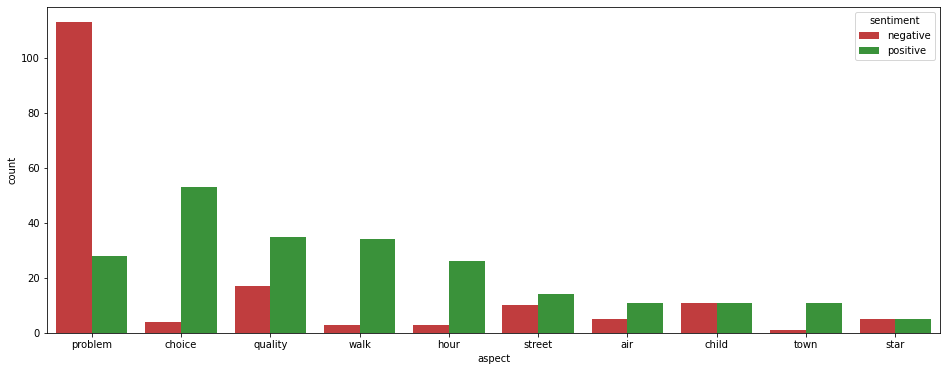

In [47]:
plot_last_five_aspects = groped_aspects_summary_.query("aspect==['choice','street','problem','walk','hour','child','air','quality','town','star']")
plt.figure(figsize=(16, 6))
sns.barplot(x = "aspect", y="count", hue = "sentiment", data=plot_last_five_aspects, palette={"negative": palette[3], "positive":palette[2]})

**Remarques:**
- l'aspect 'problem' est le plus commenté négativement, car il est dans le lexicon des mots négatifs.
- il y a presque une égalité entre la répartition des sentiments positifs et négatifs dans les 5 derniers aspects.

#### Idées d'amélioration pour la partie de classification

- le corpus utilisé contient 2006 mots positifs et 4783 négatifs, on peut changer le corpus utilisé par SentiWordNet pour avoir plus de mots.
- Ajouter plus de graphique pour la partie de visualisation des résultats (comme: la répartition des sentiment selon le rating, la répartition des sentiment selon les aspects similaires).
- Au lieu d'extraire le sentiment en premier, après on utilise les règles sur les dépendances pour extraire l'aspect lié au sentiment. On peut inverser la procédure pour extraire l'aspect en premier, après on extrait le sentiment lié à l'aspect.

### Références
Articles :
- Multiaspect‐based opinion classification model for tourist reviews
- A Hybrid Co‑occurrence and Ranking‑based Approach for Detection of Implicit Aspects in Aspect‑Based Sentiment Analysis
- A novel deterministic approach for aspect-based opinion mining in tourism products reviews

Blogs :
- Aspect-Based Opinion Mining (NLP with Python)